In [1]:
# Import Packages
import numpy as np
import scipy.optimize as opt

In [2]:
# Define Parameters
gamma = 2.5
epsilon = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
tau = 0.05

## Problem 5 Algebraic Solution
From the intertemporal euler equation we know:  
$$1 = \beta((\bar{r}-\delta)(1-\tau)+1)$$  
So we can solve for $\bar{r}$:

In [3]:
r_alg = (1/beta-1)/(1-tau)+delta
print(r_alg)

0.1214822771213749


Now that we know the steady state interest rate, we can plug it into the firm's FOC for capital 
$$\bar{r} = \alpha\bar{k}^{\alpha-1}$$to solve for the value of k

In [4]:
k_alg = (r_alg/alpha) ** (1/(alpha-1))
print(k_alg)

7.287497950692988


## Problem 5 and Problem 6 Numerical Solution
Now we would like to find the steady state values for the model specifications in problem 5 and 6 numerically.

In [5]:
def get_cbar(w, r, k, l):
    c_bar = w * l + (r - delta) * k
    return c_bar

def get_rbar(k, l):
    r_bar = alpha * (l/k) ** (1 - alpha)
    return r_bar

def get_wbar(k, l):
    w_bar = (1 - alpha) * (k/l) ** alpha
    return w_bar
    
def euler_eqns(soln, *args):
    gamma, epsilon, beta, alpha, a, delta, tau, problem_5 = args
    if problem_5 is False:
        w = get_wbar(soln[0], soln[1])
        r = get_rbar(soln[0], soln[1])
        c = get_cbar(w, r, soln[0], soln[1])
        eq1 = c ** (-gamma) - beta * (c ** (-gamma)* ((1 - tau) * (r - delta) + 1))
        eq2 = a * (1 - soln[1]) ** (-epsilon) - c ** (-gamma) * w * (1 - tau)  
        errors = np.array([eq1, eq2])
    else:
        w = get_wbar(soln, 1)
        r = get_rbar(soln, 1)
        c = get_cbar(w, r, soln, 1)
        errors = c ** (-gamma) - beta * (c ** (-gamma)* ((1 - tau) * (r - delta) + 1))
    return errors

In [6]:
args1 = (gamma, epsilon, beta, alpha, a, delta, tau, True)
args2 = (gamma, epsilon, beta, alpha, a, delta, tau, False)
result1 = opt.fsolve(euler_eqns, 1, args = (args1))
result2 = opt.fsolve(euler_eqns, np.array([1, 0.8]), args = (args2))
print("steady-state capital for problem 5 is: "+str(result1))
print("steady-state capital and labor for problem 6 are: "+str(result2))

steady-state capital for problem 5 is: [ 7.28749795]
steady-state capital and labor for problem 6 are: [ 4.22522903  0.57979145]


So the numerical and algebraic solutions for problem 5 are the same.

## Problem 8

In [19]:
# Import Additional Packages
import matplotlib.pyplot as plt
import ar1_approx as ar1
import time

In [26]:
# Specify Parameters
alpha = 0.35
beta = 0.98
rho = 0.95
sigma = 0.02
k_bar = (alpha * beta) ** (1/(1 - alpha))
print(k_bar)

0.1927826194504225


In [21]:
# Discretize State Space
# K grid
k_lb = 0.5 * k_bar
k_ub = 1.5 * k_bar
kgrid = np.linspace(k_lb, k_ub, 25)
sizek = len(kgrid)

# z grid
step = 10 * sigma/25
pi, zgrid = ar1.rouwen(rho, 0, step, 25)
sizez = len(zgrid)

In [22]:
# Define utility function
u = np.zeros((sizek, sizek, sizez))
for i in range(sizek):
    for j in range(sizek):
        for k in range(sizez):
            u[i, j, k] = np.log(np.exp(zgrid[k]) * kgrid[i] ** alpha - kgrid[j])

In [23]:
# Value Function Iteration
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek, sizez))  # initial guess of value function
Vmat = np.zeros((sizek, sizek, sizez))  # initialize Vmat matrix
VFiter = 1

start = time.time()
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez): # loop over z
                Vmat[i, j, k] = u[i, j, k] + beta * np.dot(V[j, :], pi[:, k])
    
    # iteration for graphing later
    V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1
end = time.time()

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
    print('Time taken for convergence:' + str(end - start))
else:
    print('Value function did not converge')

Value function converged after this many iterations: 686
Time taken for convergence:30.377734899520874


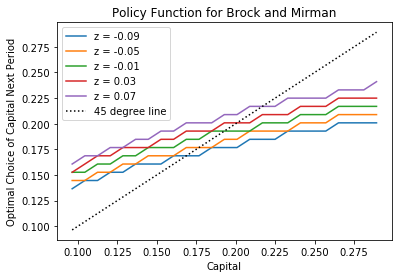

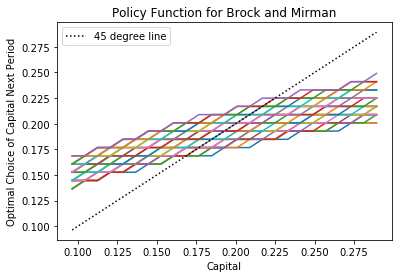

In [32]:
# Policy Function Plot
optK = kgrid[PF]
for i in range(1, 25, 5):
    plt.plot(kgrid, optK[:, i], label=str('z = ' + "%.2f" %zgrid[i]))
plt.plot(kgrid, kgrid, 'k:', label='45 degree line')
plt.xlabel('Capital')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.legend()
plt.title('Policy Function for Brock and Mirman')
plt.show()

for i in range(25):
    plt.plot(kgrid, optK[:, i])
plt.plot(kgrid, kgrid, 'k:', label='45 degree line')
plt.xlabel('Capital')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.legend()
plt.title('Policy Function for Brock and Mirman')
plt.show()